In [10]:
from common.data_frame_columns import TIMESTAMP
from common.data_frame_columns import PM10, PM2_5, PM1
from common.date_time_helper import convert_to_datetime
from common.endpoints_urls import endpoints_config
from data_management.data_crawler import DataManager
from data_management.labeled_data_generator import LabeledDataGenerator, DataLabel

In [11]:
date_strings = ['01.01.2021 00:00', '31.12.2023 23:59']
test_dates_string = ['01.01.2024 00:00', '30.04.2024 23:59']

training_dates = [convert_to_datetime(date_strings[0]), convert_to_datetime(date_strings[1])]
test_dates = [convert_to_datetime(test_dates_string[0]), convert_to_datetime(test_dates_string[1])]

datas = DataManager(True).get_all_endpoints_data(endpoints_config, update=False)

column = PM10
L = LabeledDataGenerator(column)

test_data = L.generate_labeled_data(datas[:1], test_dates[0], test_dates[1], 50, 60)
# single_data = L.generate_labeled_data(datas[:1], training_dates[0], training_dates[1], 40)
# multi_data = L.generate_labeled_data(datas, training_dates[0], training_dates[1], 40)

Loading station data: Gronie  https://datahub.ki.agh.edu.pl/api/endpoints/70/data/
    # Minimal data: 2022-07-13 23:38:02+00:00
    # Maximal data: 2024-05-10 16:16:39+00:00
Loading station data: Urząd Gminy  https://datahub.ki.agh.edu.pl/api/endpoints/71/data/
    # Minimal data: 2023-10-28 07:17:18+00:00
    # Maximal data: 2024-05-10 16:15:37+00:00
Loading station data: Młynne  https://datahub.ki.agh.edu.pl/api/endpoints/72/data/
    # Minimal data: 2022-02-12 21:11:18+00:00
    # Maximal data: 2024-05-10 16:15:59+00:00
Loading station data: Sucharskiego  https://datahub.ki.agh.edu.pl/api/endpoints/73/data/
    # Minimal data: 2021-10-07 19:41:43+00:00
    # Maximal data: 2024-05-10 16:19:11+00:00
Loading station data: Twardowskiego  https://datahub.ki.agh.edu.pl/api/endpoints/74/data/
    # Minimal data: 2021-10-07 20:59:56+00:00
    # Maximal data: 2024-05-10 16:20:04+00:00
Loading station data: Konopnickiej  https://datahub.ki.agh.edu.pl/api/endpoints/75/data/
    # Minimal data

In [14]:
from collections import Counter
from detectors.z_score_detector import ZScoreDetector
import pandas as pd

column = PM10
thresholds = [1.0, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


def debug_print(stat, level, threshold, TP, TN, FP, FN, anomaly, normal):
    # print(
    #     f'    [Threshold: {threshold}] Anomaly: {TP}/{anomaly} ({round(TP / anomaly * 100, 2)}) | Normal {round(TN / normal * 100, 2)} | {round((TP + TN) / (anomaly + normal) * 100, 2)}%')

    acc = round((TP + TN) / (TP + TN + FP + FN), 2)
    precision = round(TP / (TP + FN), 2)
    recall = round(TP / (TP + FN), 2)
    f1 = round(2 * ((precision * recall) / (precision + recall)), 2)

    print(f'{stat} & {level.title()} & {threshold} & {acc} & {precision} & {recall} & {f1} \\\\')
    print('\hline')
    #  MAD & Sensor & 8 & 10 & 12 & 67.62 \\

    # counted_values = Counter(wrong_predicted)
    # # Print the counts
    # for value, count in counted_values.items():
    #     print(f"{value}: {count}")


final_results = []

#single sensor detection
name = 'MAD_sensor_level'

zscore = ZScoreDetector()
wrong_predicted = []
mid_results = []
level = 'sensor'
stat = 'MAD'
print(f'{name}:')
for threshold in thresholds:
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    anomaly = 0
    normal = 0
    for dataframe, label in test_data:
        if not dataframe.empty:
            start_time = dataframe[TIMESTAMP].min()
            end_time = dataframe[TIMESTAMP].max()
            outliers = ZScoreDetector().detect_by_mad(dataframe, column, start_time, end_time, threshold)
            if label.value > 0:
                anomaly += 1
                if (len(outliers) > 5):
                    TP += 1
                else:
                    FN += 1
                    wrong_predicted.append(label)
            elif label.value == 0:
                normal += 1
                if (len(outliers) > 5):
                    FP += 1
                else:
                    TN += 1

    debug_print(stat, level, threshold, TP, TN, FP, FN, anomaly, normal)
    mid_results.append([name, threshold, round((TP + TN) / (anomaly + normal) * 100, 2)])

final_results.append(mid_results)

wrong_predicted = []
name = 'AVG_sensor_level'
print(f"{name}:")
level = 'sensor'
stat = 'AVG'
mid_results = []
for threshold in thresholds:
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    anomaly = 0
    normal = 0
    for dataframe, label in test_data:
        if not dataframe.empty:
            start_time = dataframe[TIMESTAMP].min()
            end_time = dataframe[TIMESTAMP].max()
            outliers = ZScoreDetector().detect_by_avg(dataframe, column, start_time, end_time, threshold)
            if label.value > 0:
                anomaly += 1
                if (len(outliers) > 5):
                    TP += 1
                else:
                    FN += 1
                    wrong_predicted.append(label)
            elif label.value == 0:
                normal += 1
                if (len(outliers) > 5):
                    FP += 1
                else:
                    TN += 1

    debug_print(stat, level, threshold, TP, TN, FP, FN, anomaly, normal)
    mid_results.append([name, threshold, round((TP + TN) / (anomaly + normal) * 100, 2)])

final_results.append(mid_results)

name = 'MAD_network_level'
wrong_predicted = []
mid_results = []
print(f"{name}:")
level = 'network'
stat = 'MAD'
for threshold in thresholds:
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    anomaly = 0
    normal = 0
    for dataframe, label in test_data:
        if not dataframe.empty:
            start_time = dataframe[TIMESTAMP].min()
            end_time = dataframe[TIMESTAMP].max()
            outliers = ZScoreDetector().detect_by_mad_network_level(datas, dataframe, column, start_time, end_time,
                                                                    threshold)
            if label.value > 0:
                anomaly += 1
                if (len(outliers) > 5):
                    TP += 1
                else:
                    FN += 1
                    wrong_predicted.append(label)
            elif label.value == 0:
                normal += 1
                if (len(outliers) > 5):
                    FP += 1
                else:
                    TN += 1

    debug_print(stat, level, threshold, TP, TN, FP, FN, anomaly, normal)
    mid_results.append([name, threshold, round((TP + TN) / (anomaly + normal) * 100, 2)])

final_results.append(mid_results)

wrong_predicted = []
name = 'AVG_network_level'
mid_results = []
level = 'network'
stat = 'AVG'
print(f"{name}")
for threshold in thresholds:
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    anomaly = 0
    normal = 0
    for dataframe, label in test_data:
        if not dataframe.empty:
            start_time = dataframe[TIMESTAMP].min()
            end_time = dataframe[TIMESTAMP].max()
            outliers = ZScoreDetector().detect_by_avg_network_level(datas, dataframe, column, start_time, end_time,
                                                                    threshold)

            if label.value > 0:
                anomaly += 1
                if (len(outliers) > 5):
                    TP += 1
                else:
                    FN += 1
                    wrong_predicted.append(label)
            elif label.value == 0:
                normal += 1
                if (len(outliers) > 5):
                    FP += 1
                else:
                    TN += 1

    debug_print(stat, level, threshold, TP, TN, FP, FN, anomaly, normal)
    mid_results.append([name, threshold, round((TP + TN) / (anomaly + normal) * 100, 2)])

final_results.append(mid_results)


MAD_sensor_level:
MAD & Sensor & 1.0 & 0.5 & 0.96 & 0.96 & 0.96 \\
\hline
MAD & Sensor & 1.5 & 0.47 & 0.87 & 0.87 & 0.87 \\
\hline
MAD & Sensor & 2 & 0.46 & 0.69 & 0.69 & 0.69 \\
\hline
MAD & Sensor & 3 & 0.49 & 0.56 & 0.56 & 0.56 \\
\hline
MAD & Sensor & 4 & 0.5 & 0.39 & 0.39 & 0.39 \\
\hline
MAD & Sensor & 5 & 0.54 & 0.35 & 0.35 & 0.35 \\
\hline
MAD & Sensor & 6 & 0.61 & 0.35 & 0.35 & 0.35 \\
\hline
MAD & Sensor & 7 & 0.62 & 0.33 & 0.33 & 0.33 \\
\hline
MAD & Sensor & 8 & 0.6 & 0.3 & 0.3 & 0.3 \\
\hline
MAD & Sensor & 9 & 0.61 & 0.3 & 0.3 & 0.3 \\
\hline
MAD & Sensor & 10 & 0.61 & 0.3 & 0.3 & 0.3 \\
\hline
MAD & Sensor & 11 & 0.6 & 0.26 & 0.26 & 0.26 \\
\hline
MAD & Sensor & 12 & 0.61 & 0.26 & 0.26 & 0.26 \\
\hline
MAD & Sensor & 13 & 0.6 & 0.24 & 0.24 & 0.24 \\
\hline
MAD & Sensor & 14 & 0.6 & 0.24 & 0.24 & 0.24 \\
\hline
MAD & Sensor & 15 & 0.6 & 0.24 & 0.24 & 0.24 \\
\hline
MAD & Sensor & 16 & 0.6 & 0.24 & 0.24 & 0.24 \\
\hline
MAD & Sensor & 17 & 0.6 & 0.24 & 0.24 & 0.24 \\
\hlin

Plotting Accuracy (ZScore)


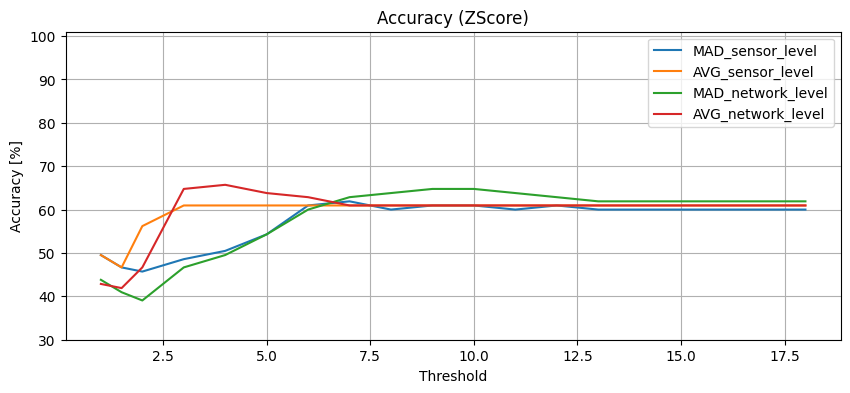

In [13]:
from matplotlib import pyplot as plt


def draw_results(final_results, title):
    print(f"Plotting {title}")
    plt.figure(figsize=(10, 4))

    for result in final_results:
        name = result[0][0]
        plt.plot([x[1] for x in result], [x[2] for x in result], label=name)

    plt.xlabel('Threshold')
    plt.ylabel('Accuracy [%]')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.ylim(30, 101)
    plt.show()


draw_results(final_results, "Accuracy (ZScore)")


In [16]:
from detectors.pseudo_periodic import PseudoPeriodicDetector
import pandas as pd

column = PM10
sensor_data = datas[0]
thresholds = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
windows = [1, 2, 3, 4, 8, 12]
histories = [3, 5, 7, 10, 14]
final_results = []


#single sensor detection
def debug_print(stat, level, threshold, window, history, TP, TN, FP, FN, anomaly, normal):
    # print(
    #     f'    [Threshold: {threshold}] Anomaly: {TP}/{anomaly} ({round(TP / anomaly * 100, 2)}) | Normal {round(TN / normal * 100, 2)} | {round((TP + TN) / (anomaly + normal) * 100, 2)}%')

    acc = round((TP + TN) / (TP + TN + FP + FN), 2)
    precision = round(TP / (TP + FN), 2)
    recall = round(TP / (TP + FN), 2)
    f1 = round(2 * ((precision * recall) / (precision + recall)), 2)

    if acc > 0.65:
        print(
            f'{stat} & {level.title()} & {threshold} & {window} & {history} & {acc} & {precision} & {recall} & {f1} \\\\')
        print('\hline')


name = 'PERIODIC_MAD sensor level'
zscore = "MAD"
lvl = "Sensor"
print(f"{name}:")
for window in windows:
    for history in histories:
        for threshold in thresholds:
            TP = 0
            FP = 0
            TN = 0
            FN = 0
            anomaly = 0
            normal = 0
            for dataframe, label in test_data:
                if not dataframe.empty:
                    start_time = dataframe[TIMESTAMP].min()
                    end_time = dataframe[TIMESTAMP].max()
                    destroyed = sensor_data.copy()
                    destroyed.name = sensor_data.name
                    destroyed.update(dataframe)
                    outliers = PseudoPeriodicDetector().detect_by_periodic_mad(destroyed, column, start_time, end_time,
                                                                               time_step_in_hours=4,
                                                                               threshold=threshold,
                                                                               max_depth_in_days=history)

                    if label.value > 0:
                        anomaly += 1
                        if (len(outliers) > 5):
                            TP += 1
                        else:
                            FN += 1
                            wrong_predicted.append(label)
                    elif label.value == 0:
                        normal += 1
                        if (len(outliers) > 5):
                            FP += 1
                        else:
                            TN += 1

            debug_print(zscore, lvl, threshold, window, history, TP, TN, FP, FN, anomaly, normal)
        print()

name = 'PERIODIC_AVG sensor level'
zscore = "AVG"
lvl = "Sensor"
print(f"{name}:")
for window in windows:
    for history in histories:
        for threshold in thresholds:

            TP = 0
            FP = 0
            TN = 0
            FN = 0
            anomaly = 0
            normal = 0

            for dataframe, label in test_data:
                if not dataframe.empty:

                    start_time = dataframe[TIMESTAMP].min()
                    end_time = dataframe[TIMESTAMP].max()
                    destroyed = sensor_data.copy()
                    destroyed.name = sensor_data.name
                    destroyed.update(dataframe)
                    outliers = PseudoPeriodicDetector().detect_by_periodic_avg(destroyed, column, start_time, end_time,
                                                                               time_step_in_hours=4,
                                                                               threshold=threshold,
                                                                               max_depth_in_days=history)

                    if label.value > 0:
                        anomaly += 1
                        if (len(outliers) > 5):
                            TP += 1
                        else:
                            FN += 1
                            wrong_predicted.append(label)
                    elif label.value == 0:
                        normal += 1
                        if (len(outliers) > 5):
                            FP += 1
                        else:
                            TN += 1

            debug_print(zscore, lvl, threshold, window, history, TP, TN, FP, FN, anomaly, normal)
        print()

name = 'PERIODIC_MAD network level'
zscore = "MAD"
lvl = "Network"
print(f"{name}:")
for window in windows:
    for history in histories:
        for threshold in thresholds:
            TP = 0
            FP = 0
            TN = 0
            FN = 0
            anomaly = 0
            normal = 0
            for dataframe, label in test_data:
                if not dataframe.empty:
                    start_time = dataframe[TIMESTAMP].min()
                    end_time = dataframe[TIMESTAMP].max()
                    destroyed = sensor_data.copy()
                    destroyed.name = sensor_data.name
                    destroyed.update(dataframe)
                    outliers = PseudoPeriodicDetector().detect_by_periodic_mad_network_level(datas, destroyed, column,
                                                                                             start_time, end_time,
                                                                                             time_step_in_hours=4,
                                                                                             threshold=threshold,
                                                                                             max_depth_in_days=history)
                    if label.value > 0:
                        anomaly += 1
                        if (len(outliers) > 5):
                            TP += 1
                        else:
                            FN += 1
                            wrong_predicted.append(label)
                    elif label.value == 0:
                        normal += 1
                        if (len(outliers) > 5):
                            FP += 1
                        else:
                            TN += 1

            debug_print(zscore, lvl, threshold, window, history, TP, TN, FP, FN, anomaly, normal)
        print()

name = 'PERIODIC_AVG network level'
zscore = "AVG"
lvl = "Network"
print(f"{name}:")
for window in windows:
    for history in histories:
        for threshold in thresholds:
            TP = 0
            FP = 0
            TN = 0
            FN = 0
            anomaly = 0
            normal = 0
            for dataframe, label in test_data:
                if not dataframe.empty:
                    start_time = dataframe[TIMESTAMP].min()
                    end_time = dataframe[TIMESTAMP].max()
                    destroyed = sensor_data.copy()
                    destroyed.name = sensor_data.name
                    destroyed.update(dataframe)
                    outliers = PseudoPeriodicDetector().detect_by_periodic_avg_network_level(datas, destroyed, column,
                                                                                             start_time, end_time,
                                                                                             time_step_in_hours=4,
                                                                                             threshold=threshold,
                                                                                             max_depth_in_days=history)
                    if label.value > 0:
                        anomaly += 1
                        if (len(outliers) > 5):
                            TP += 1
                        else:
                            FN += 1
                            wrong_predicted.append(label)
                    elif label.value == 0:
                        normal += 1
                        if (len(outliers) > 5):
                            FP += 1
                        else:
                            TN += 1
            debug_print(zscore, lvl, threshold, window, history, TP, TN, FP, FN, anomaly, normal)
        print()


PERIODIC_MAD sensor level:
MAD & Sensor & 6 & 1 & 10 & 0.66 & 0.33 & 0.33 & 0.33 \\
\hline
MAD & Sensor & 7 & 1 & 10 & 0.66 & 0.33 & 0.33 & 0.33 \\
\hline
MAD & Sensor & 4 & 1 & 14 & 0.67 & 0.43 & 0.43 & 0.43 \\
\hline
MAD & Sensor & 6 & 2 & 10 & 0.66 & 0.33 & 0.33 & 0.33 \\
\hline
MAD & Sensor & 7 & 2 & 10 & 0.66 & 0.33 & 0.33 & 0.33 \\
\hline
MAD & Sensor & 4 & 2 & 14 & 0.67 & 0.43 & 0.43 & 0.43 \\
\hline
MAD & Sensor & 6 & 3 & 10 & 0.66 & 0.33 & 0.33 & 0.33 \\
\hline
MAD & Sensor & 7 & 3 & 10 & 0.66 & 0.33 & 0.33 & 0.33 \\
\hline
MAD & Sensor & 4 & 3 & 14 & 0.67 & 0.43 & 0.43 & 0.43 \\
\hline
MAD & Sensor & 6 & 4 & 10 & 0.66 & 0.33 & 0.33 & 0.33 \\
\hline
MAD & Sensor & 7 & 4 & 10 & 0.66 & 0.33 & 0.33 & 0.33 \\
\hline
MAD & Sensor & 4 & 4 & 14 & 0.67 & 0.43 & 0.43 & 0.43 \\
\hline
MAD & Sensor & 6 & 8 & 10 & 0.66 & 0.33 & 0.33 & 0.33 \\
\hline
MAD & Sensor & 7 & 8 & 10 & 0.66 & 0.33 & 0.33 & 0.33 \\
\hline
MAD & Sensor & 4 & 8 & 14 & 0.67 & 0.43 & 0.43 & 0.43 \\
\hline
MAD & Sensor 